## CS310 Natural Language Processing
## Assignment 3 (part 2). Named Entity Recognition with Bi-LSTM

**Total points**: 30 + 20 bonus points

In this assignment, you will train a bidirectional LSTM model on the CoNLL2003 English named entity recognition task set and evaluate its performance.

For the bonus questions, submit them as separate notebook files.

### 0. Import Necessary Libraries

In [24]:
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

from pprint import pprint
from collections import Counter

from utils import CorpusReader
import re


In [25]:
#Data Processing
class Vocabulary:
    def __init__(self, min_freq=2):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<BOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<BOS>', 3: '<EOS>'}
        self.min_freq = min_freq

    def build_vocab(self, text):
        word_counts = Counter(text)
        valid_words = [word for word, count in word_counts.items() if count >= self.min_freq]

        for word in valid_words:
            if word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word

    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    def __init__(self, text, vocab, seq_length):
        self.vocab = vocab
        self.seq_length = seq_length

        self.data = [self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>']) for word in text]

        self.sequences = []
        for i in range(0, len(self.data) - seq_length, 1):
            seq = self.data[i:i + seq_length]
            target = self.data[i + 1:i + seq_length + 1]
            self.sequences.append((seq, target))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        return torch.LongTensor(seq), torch.LongTensor(target)

def load_and_preprocess_data(file_path, seq_length=35):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()

    words = text.split()

    vocab = Vocabulary(min_freq=2)
    vocab.build_vocab(words)

    split_idx = int(len(words) * 0.9)
    train_words = words[:split_idx]
    test_words = words[split_idx:]

    train_dataset = TextDataset(train_words, vocab, seq_length)
    test_dataset = TextDataset(test_words, vocab, seq_length)

    return train_dataset, test_dataset, vocab



### 1. Build the Model

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                        batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        batch_size = x.size(0)

        if hidden is None:
            hidden = self.init_hidden(batch_size)
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.lstm(embedded, hidden)

        output = self.dropout(output)
        output = self.fc(output)

        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_dim),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_dim))

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_perplexities = []
    best_perplexity = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            output, hidden = model(inputs)
            
            output = output.view(-1, output.size(-1))
            targets = targets.view(-1)
            
            loss = criterion(output, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, '
                                                            f'Loss: {loss.item():.4f}')
            
            train_losses.append(loss.item())
        
        model.eval()
        total_loss = 0
        total_words = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output, hidden = model(inputs)
                output = output.view(-1, output.size(-1))
                targets = targets.view(-1)
                
                loss = criterion(output, targets)
                total_loss += loss.item() * targets.size(0)
                total_words += targets.size(0)
        
        perplexity = np.exp(total_loss / total_words)
        test_perplexities.append(perplexity)
        
        print(f'Epoch: {epoch+1}/{num_epochs}, Test Perplexity: {perplexity:.4f}')
        
        # 保存最佳模型
        if perplexity < best_perplexity:
            best_perplexity = perplexity
            torch.save(model.state_dict(), 'best_lstm_model.pth')
    
    return train_losses, test_perplexities

def generate_text(model, vocab, prefix, max_length=50, temperature=1.0):
    model.eval()
    words = prefix.lower().split()
    device = next(model.parameters()).device
    
    # 转换前缀词为索引
    input_indices = [vocab.word2idx.get(word, vocab.word2idx['<UNK>']) for word in words]
    input_tensor = torch.LongTensor([input_indices]).to(device)
    
    with torch.no_grad():
        hidden = None
        generated_words = words.copy()
        
        for _ in range(max_length):
            output, hidden = model(input_tensor, hidden)
            
            # 获取最后一个时间步的预测
            word_weights = output[0, -1].div(temperature).exp()
            word_idx = torch.multinomial(word_weights, 1)[0]
            
            # 将生成的词添加到结果中
            generated_word = vocab.idx2word[word_idx.item()]
            generated_words.append(generated_word)
            
            # 准备下一个输入
            input_tensor = torch.LongTensor([[word_idx]]).to(device)
            
            if generated_word == '':
                break
    
    return ' '.join(generated_words)

### 2. Train and Evaluate

In [27]:
# 设置参数
EMBEDDING_DIM = 200  # 增加嵌入维度
HIDDEN_DIM = 256    # 增加隐藏层维度
NUM_LAYERS = 2
BATCH_SIZE = 512
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
SEQUENCE_LENGTH = 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据
file_path = 'Harry_Potter_all_books_preprocessed.txt'
train_dataset, test_dataset, vocab = load_and_preprocess_data(file_path, SEQUENCE_LENGTH)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 初始化模型
model = LSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 训练模型
train_losses, test_perplexities = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    NUM_EPOCHS, DEVICE
)

Epoch: 1/20, Batch: 0/1912, Loss: 9.7689


KeyboardInterrupt: 


Prefix: Harry looked at
Generated: harry looked at him looking stern .harry i am too bad .well then she said how to get a real tea and talked .er its tryin to come ?and now he would have noticed a lost charm or what was having all in the flames to the staffroom as he would be listening

Prefix: Harry looked over
Generated: harry looked over at him .for a moment so to her out of harry .it was almost a little glance back at him between his wand once .he sat at a entrance room .hagrid realized about hagrid and his godfather was a shout of mingled loathing .ron had another appraising least face he

Prefix: Harry looked around
Generated: harry looked around into the place what to worry about how much he might on thursday table and listening .they composed across the field where they were filing and calm at the waters <UNK> by the the dark mark ahead of the golden schools and notices hogwarts except their news hurt meaning that

Prefix: Harry looked at the
Generated: harry looked at the wit

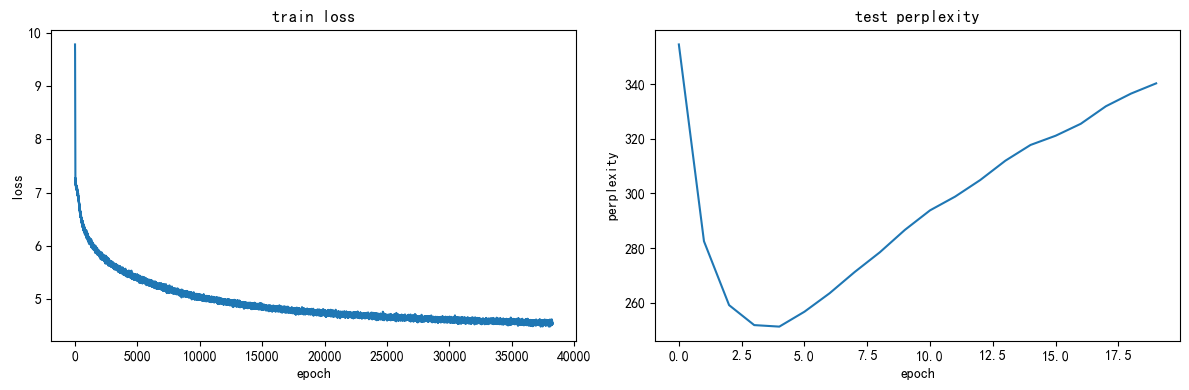

In [ ]:
test_prefixes = [
    "Harry looked at",
    "Harry looked over",
    "Harry looked around",
    "Harry looked at the",
    "Harry looked at the door",
]

model = LSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()

for prefix in test_prefixes:
    generated = generate_text(model, vocab, prefix)
    print(f"\nPrefix: {prefix}")
    print(f"Generated: {generated}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(test_perplexities)
plt.title('test perplexity')
plt.xlabel('epoch')
plt.ylabel('perplexity')

plt.tight_layout()
plt.show()

In [ ]:


# Condition A: 随机初始化
model_rand = LSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
optimizer_rand = torch.optim.Adam(model_rand.parameters(), lr=LEARNING_RATE)
train_losses_rand, test_perps_rand = train_model(
    model_rand, train_loader, test_loader, criterion, optimizer_rand, NUM_EPOCHS, DEVICE
)



Epoch: 1/20, Batch: 0/1912, Loss: 9.7719
Epoch: 1/20, Batch: 100/1912, Loss: 7.0769
Epoch: 1/20, Batch: 200/1912, Loss: 7.0422
Epoch: 1/20, Batch: 300/1912, Loss: 6.8407
Epoch: 1/20, Batch: 400/1912, Loss: 6.6435
Epoch: 1/20, Batch: 500/1912, Loss: 6.5399
Epoch: 1/20, Batch: 600/1912, Loss: 6.3899
Epoch: 1/20, Batch: 700/1912, Loss: 6.2861
Epoch: 1/20, Batch: 800/1912, Loss: 6.2343
Epoch: 1/20, Batch: 900/1912, Loss: 6.2392
Epoch: 1/20, Batch: 1000/1912, Loss: 6.2129
Epoch: 1/20, Batch: 1100/1912, Loss: 6.0813
Epoch: 1/20, Batch: 1200/1912, Loss: 6.0994
Epoch: 1/20, Batch: 1300/1912, Loss: 6.0681
Epoch: 1/20, Batch: 1400/1912, Loss: 5.9774
Epoch: 1/20, Batch: 1500/1912, Loss: 6.0043
Epoch: 1/20, Batch: 1600/1912, Loss: 5.9399
Epoch: 1/20, Batch: 1700/1912, Loss: 5.8950
Epoch: 1/20, Batch: 1800/1912, Loss: 5.8869
Epoch: 1/20, Batch: 1900/1912, Loss: 5.8614
Epoch: 1/20, Test Perplexity: 356.8573
Epoch: 2/20, Batch: 0/1912, Loss: 5.8805
Epoch: 2/20, Batch: 100/1912, Loss: 5.8370
Epoch: 2/

NameError: name 'api' is not defined

In [ ]:
def load_glove_embeddings(glove_path, Vocab):
    glove_embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            vector = np.array(split_line[1:], dtype=np.float32)
            glove_embeddings[word] = vector

    # 创建预训练嵌入矩阵
    embedding_matrix = np.zeros((len(Vocab), EMBEDDING_DIM))
    for word, idx in Vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            embedding_matrix[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

    return torch.tensor(embedding_matrix, dtype=torch.float32)

glove_path = "glove.6B.200d.txt"
glove_embeddings = load_glove_embeddings(glove_path, vocab)

model_glove = LSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
model_glove.embedding.weight.data.copy_(glove_embeddings)
optimizer_glove = torch.optim.Adam(model_glove.parameters(), lr=LEARNING_RATE)
train_losses_glove, test_perps_glove = train_model(
    model_glove, train_loader, test_loader, criterion, optimizer_glove, NUM_EPOCHS, DEVICE
)



KeyboardInterrupt: 

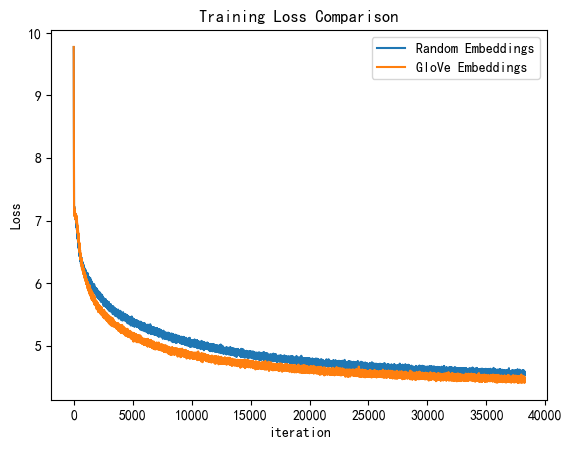

Random Embeddings Final Perplexity: 350.45683045604017
GloVe Embeddings Final Perplexity: 354.7701542382459


In [31]:
# 绘制对比训练损失曲线
plt.plot(train_losses_rand, label='Random Embeddings')
plt.plot(train_losses_glove, label='GloVe Embeddings')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()

# 输出最终测试集困惑度
print("Random Embeddings Final Perplexity:", test_perps_rand[-1])
print("GloVe Embeddings Final Perplexity:", test_perps_glove[-1])

In [33]:
# Report the final perplexity scores on test set.

print("Random Embeddings Final Perplexity:", test_perps_rand[-1])
print("GloVe Embeddings Final Perplexity:", test_perps_glove[-1])

# Report the best perplexity scores on test set.
print("Best Random Embeddings Perplexity:", min(test_perps_rand))
print("Best GloVe Embeddings Perplexity:", min(test_perps_glove))

Random Embeddings Final Perplexity: 350.45683045604017
GloVe Embeddings Final Perplexity: 354.7701542382459
Best Random Embeddings Perplexity: 252.679727177254
Best GloVe Embeddings Perplexity: 239.7205948494848
